In [47]:
import json
import re
import unicodedata

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline

In [4]:
ids = pd.read_csv("ids.txt", sep="\t", header=None, comment="#",
                  names=["codepoint", "character", "decomposition"]).set_index("codepoint")

In [5]:
# Load radical data.
with open("unihan-json/kRSKangXi.json", "r") as rad_f:
    rad_dict = json.load(rad_f)
    rad_dict = {char: int(vals.split(".")[0]) for char, vals in rad_dict.items()}

In [6]:
# Load pronunciation / tone / frequency data.
with open("unihan-json/kHanyuPinlu.json", "r") as hanyu_f:
    hanyu_dict = json.load(hanyu_f)
    # Retain the max-frequency reading.
    hanyu_dict = {char: max([(freq, reading) for reading, freq in readings.items()])
                  for char, readings in hanyu_dict.items()}

In [7]:
tone_string_re = re.compile(r"^([^\d]*)([1-5]?)([^\d]*)$", flags=re.UNICODE)
table = {0x304: ord('1'), 0x301: ord('2'), 0x30c: ord('3'),
         0x300: ord('4')}
def analyze_tone(s):
    """
    Analyze tone and segmental content of a single character.
    """
    if s is None:
        return None, None
    analyzed = unicodedata.normalize("NFD", s).translate(table)
    try:
        start, tone_num, end = tone_string_re.findall(analyzed)[0]
    except IndexError:
        print(s, analyzed)
        return 
    
    tone_num = int(tone_num) if tone_num else 5
    return start + end, tone_num

In [8]:
ids["radical"] = ids.character.map(rad_dict)
ids["frequency"], ids["pinyin"] = zip(*ids.character.map(hanyu_dict).apply(lambda x: (None, None) if x is np.nan else x))
ids["pinyin_toneless"], ids["tone"] = zip(*ids.pinyin.map(analyze_tone))

In [9]:
ids.head()

,character,decomposition,radical,frequency,pinyin,pinyin_toneless,tone
codepoint,,,,,,,
U+03B1,α,α,NaN,None,None,None,None
U+2113,ℓ,ℓ,NaN,None,None,None,None
U+2460,①,①,NaN,None,None,None,None
U+2461,②,②,NaN,None,None,None,None
U+2462,③,③,NaN,None,None,None,None


In [10]:
ids.to_csv("joined_data.csv")

----

Drop entries missing data.

In [11]:
ids = ids.dropna()
ids["frequency"] = ids.frequency.astype(int)
len(ids)

3799

---

Fetch candidate characters for analysis, which have a primary decomposition of semantic + phonetic radical.

In [12]:
two_rads = ids[ids.decomposition.str.len() == 3]
two_rads = pd.concat([two_rads,
                      two_rads.decomposition.apply(lambda x: pd.Series(list(x))).rename(columns={0: "layout", 1: "first", 2: "second"})],
                     axis=1)
two_rads.head()

,character,decomposition,radical,frequency,pinyin,pinyin_toneless,tone,layout,first,second
codepoint,,,,,,,,,,
U+4E01,丁,⿱一亅,1.0,16,dīng,ding,1,⿱,一,亅
U+4E03,七,⿻㇀乚,1.0,950,qī,qi,1,⿻,㇀,乚
U+4E09,三,⿱一二,1.0,3030,sān,san,1,⿱,一,二
U+4E0A,上,⿱⺊一,1.0,12308,shàng,shang,4,⿱,⺊,一
U+4E0B,下,⿱一卜,1.0,6430,xià,xia,4,⿱,一,卜


In [13]:
analysis_chars = two_rads[two_rads.layout == "⿰"]
analysis_chars.head()

,character,decomposition,radical,frequency,pinyin,pinyin_toneless,tone,layout,first,second
codepoint,,,,,,,,,,
U+4E71,乱,⿰舌乚,5.0,357,luàn,luan,4,⿰,舌,乚
U+4E73,乳,⿰孚乚,5.0,24,rǔ,ru,3,⿰,孚,乚
U+4E82,亂,⿰𤔔乚,5.0,357,luàn,luan,4,⿰,𤔔,乚
U+4EBF,亿,⿰亻乙,9.0,195,yì,yi,4,⿰,亻,乙
U+4EC0,什,⿰亻十,9.0,4045,shén,shen,2,⿰,亻,十


In [14]:
analysis_chars.groupby("first").size().sort_values(ascending=False).head(30)#frequency.sum().sort_values(ascending=False).head(30)

first
扌    205
氵    166
口    134
亻    114
木     99
纟     62
讠     61
忄     60
言     57
钅     49
金     48
土     42
阝     41
虫     38
火     36
石     36
女     35
禾     33
𧾷     33
犭     29
目     23
衤     21
彳     19
日     19
王     17
马     16
馬     16
车     14
月     14
冫     14
dtype: int64

In [16]:
analysis_chars.groupby("pinyin_toneless").size().sort_values(ascending=False).head(30)#frequency.sum().sort_values(ascending=False).head(30)

pinyin_toneless
ji       34
jian     31
shi      27
fu       26
yi       25
zhi      22
li       21
jiao     21
ju       19
zhu      19
xi       18
xian     18
wei      17
yan      17
yu       16
jie      15
you      15
xie      15
jing     15
bo       14
qi       14
ya       13
zhen     13
yin      13
xu       12
shu      12
yang     12
qian     12
xiang    12
e        12
dtype: int64

In [77]:
# Grouping by toneless + tone, get entropy of remaining distribution over characters.
def get_entropy(rows):
    probs = rows.frequency / rows.frequency.sum()
    return -(probs * np.log(probs) / np.log(2)).sum()

pinyin_tone_entropies = analysis_chars.groupby(["pinyin_toneless", "tone"]).apply(get_entropy)
pinyin_tone_entropies.sort_values(ascending=False).head(30)

pinyin_toneless  tone
ji               4       3.475952
xi               1       3.126805
yi               4       3.062331
jian             3       2.818978
qu               1       2.798073
jing             4       2.776677
jian             4       2.764316
zhi              2       2.758300
jiao             1       2.696775
bo               1       2.670156
fu               2       2.580945
song             4       2.513466
xie              2       2.512925
long             2       2.512336
yang             2       2.492262
shi              4       2.484392
fu               4       2.471684
ji               1       2.469102
jiao             3       2.431979
yu               4       2.425043
shu              1       2.413322
shi              1       2.396830
ling             2       2.345448
ci               2       2.297094
ya               1       2.291783
zhu              1       2.285050
zhuang           4       2.238048
zheng            1       2.230171
fu               3       2

In [78]:
pinyin_tone_entropies.median()

0.857327548790452

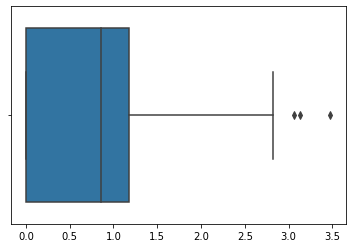

In [79]:
sns.boxplot(pinyin_tone_entropies)

In [80]:
pinyin_sem_entropies = analysis_chars.groupby(["pinyin_toneless", "first"]).apply(get_entropy)
pinyin_sem_entropies.sort_values(ascending=False).head(30)

pinyin_toneless  first
yi               亻        2.413291
fu               亻        2.181136
yin              阝        1.983324
tao              氵        1.965846
xie              扌        1.957553
xian             阝        1.912048
ji               木        1.830098
jian             扌        1.788941
                 氵        1.764218
wei              亻        1.738971
bo               扌        1.702920
jia              亻        1.633922
ne               口        1.584963
kuo              扌        1.584101
nian             扌        1.583477
xiao             口        1.583394
ban              扌        1.579592
wei              口        1.533357
po               氵        1.528097
tan              氵        1.510971
hun              氵        1.501261
xu               口        1.500000
wo               氵        1.491618
tan              扌        1.485960
ji               氵        1.485075
can              忄        1.484186
qian             氵        1.479972
hai              口        1.4422

In [81]:
pinyin_sem_entropies.median()

0.0

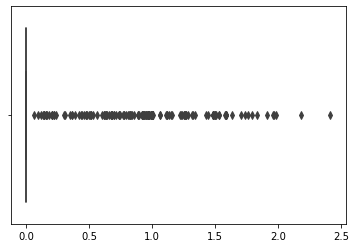

In [82]:
sns.boxplot(pinyin_sem_entropies)

In [83]:
summary_df = pd.concat([pinyin_sem_entropies.groupby("pinyin_toneless").mean(),
                        pinyin_tone_entropies.groupby("pinyin_toneless").mean()],
                       axis=1, keys=["semantic", "tone"])

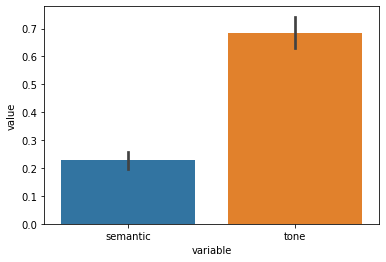

In [84]:
sns.barplot(x="variable", y="value", data=summary_df.reset_index().melt(id_vars=["pinyin_toneless"]))

In [85]:
summary_df

,semantic,tone
pinyin_toneless,,
a,0.415160,0.441405
ai,0.166667,0.833800
an,0.200000,0.685944
ao,0.000000,0.000000
ba,0.433395,0.218649
...,...,...
zong,0.986017,0.559039
zu,0.000000,0.292517
zuan,0.000000,0.500000


In [86]:
stats.ttest_rel(summary_df.semantic, summary_df.tone)

Ttest_relResult(statistic=-17.370841537934375, pvalue=1.861006079167013e-49)